# TalkingData数据集相关代码及结果

- 从文件中读取数据并加窗的函数

In [74]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
# import seaborn as sns
from localtsfresh.tsfresh import extract_features, extract_relevant_features, select_features
from localtsfresh.tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from tsfresh.feature_selection.significance_tests import target_real_feature_real_test
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from pandas import DataFrame
import pandas as pd
import numpy as np
import os
import math

import logging

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import butter, lfilter, lfilter_zi
from numpy import linalg as LA
from xgboost import XGBClassifier
import copy
from collections import Counter

# We set the logger to Error level
# This is not recommend for normal use as you can oversee important Warning messages
logging.basicConfig(level=logging.ERROR)

#根据Win，生成DataFrame格式中的Time列
def getTimeColumn(win):
    time=np.arange(win)
    for idx in range(1, sensornum):
        timetmp=np.arange(win)
        time=np.concatenate((time, timetmp), axis=0)
    time.shape=(len(time),1)
    return time

#根据Win和数据，生成DataFrame格式中的kind和value列
def getKindValueColumn(sd, win):
    for i in range(sensornum):
        kind=i*np.ones((win, 1),dtype=int)
        sensorcols=sd[i]
        sensorcols.shape=(win, 1)
        sdata=np.column_stack((kind, sensorcols))
        if i==0:
            sensorframe=sdata
        else:
            sensorframe=np.row_stack((sensorframe, sdata))
    return sensorframe

def getIdColumn(num, win):
    for i in range(num):
        if i==0:
            idary=0*np.ones((sensornum*win, 1))
        else:
            idary=np.row_stack((idary, i*np.ones((sensornum*win, 1))))
    return idary

def getDataLabelColumn(dataary,label, num, win):
    for i in range(filenum):
        if i==0:
            y=label[travel[i]][:num]
            data=dataary[travel[i]][:num*win*sensornum]
        else:
            y=np.row_stack((y, label[travel[i]][:num]))
            data=np.row_stack((data, dataary[travel[i]][:num*win*sensornum]))
    y.shape=(len(y),)
    y=pd.Series(y)
    return data, y


#读取所有数据，结果是字典，分别存储六种运动的传感器读数矩阵，每个矩阵的三列分别是time, kind, value
def loadData(win, step, sampling):
    labeldict={}
    datadict={}
    files = os.listdir('/home/hadoop/data')
    if step<=win:
        for i in range(0, filenum):
            with open('/home/hadoop/data/%s' % files[i], 'r') as f:
                sensordata=np.loadtxt(f, delimiter=",")[::2, :]
                
                ########## feature extraction ###########
                sensordata = np.delete(sensordata, np.s_[:3], 1)
                sensordata[:, 2] = sensordata[:, 2] - 9.8012
                sensordata = resample(sensordata, sampling)
                
                #mi = LA.norm(sensordata, 2, axis=1)
                #sma = np.sum(np.abs(sensordata), 1)
                #velo = calcVelo(sensordata[:,:2], fs, win)
                #sensordata = np.c_[sensordata, mi, sma]
                
                #loadDataPlot(sensordata, i)
                
                ########## filter ############
                #fltr2(sensordata, cutOff=15, fs=fs, order=5)
                #########################################
                
                max_num=int((len(sensordata)-win)/step)+1
                for j in range(0, max_num):
                    start_idx=step*j
                    end_idx=step*j+win
                    sd=sensordata[start_idx:end_idx,:]
                    sd=sd.transpose()
                        
                    time=getTimeColumn(win)
                    kindvalue=getKindValueColumn(sd, win)
                    travary=np.column_stack((time, kindvalue ))

                    if j == 0:
                        dataarray=travary
                    else:
                        dataarray=np.concatenate((dataarray, travary), axis=0)  

                labeldict[travel[i]]=i*np.ones((max_num, 1), dtype=int)
                datadict[travel[i]]=dataarray
                print(files[i]+" loaded!")
        use_num_max=filenum*max_num
        return datadict, labeldict, use_num_max
    else:
        raise IOError('\'step\' of slide window shoud be less than \'win\'')

#从所有数据dataary和其标签label中，选出总数为num的样本，每个类别选num/sensornum个样本。
def genTrainSample(dataary, label, num, win):
    idary=getIdColumn(num, win)
    labelnum=int(num/filenum) ;
    data, y=getDataLabelColumn(dataary, label, labelnum, win)
    data=np.column_stack((idary, data))
    dataframe = DataFrame(data, columns=['id', 'time', 'kind', 'value'])
    return dataframe, y


#画出第idx个样本3个传感器的数据
def plotSample(data, kind, idx, win, use_num):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    tmp=data.iloc[:, -1].values
    for i in range(sensornum):
        plt.subplot(3,2,i+1)
        plt.title(sensor[i] + ' readings')
        begin=kind*win*use_num + idx*win*sensornum + win*i
        end=begin+win-1
        plt.plot(tmp[begin:end])
    plt.show()
    
def loadDataPlot(data, ind):
    plt.figure(ind)
    for i in xrange(0, data.shape[1]):
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.subplot(3,2,i+1)
        plt.plot(data[:, i])
    return

################ Resampling ##################

def resample(data, sampling):
    ind = np.arange(0, data.shape[0], sampling)
    return data[ind, :]

################ Calculate Velocity ###################

def calcVelo(acc, fs, win):
    velo = np.zeros(acc.shape)
    for i in xrange(0, acc.shape[0]):
        if i % win: 
            velo[i] = velo[i-1] + (acc[i-1]+acc[i])/(2*fs)
    return LA.norm(velo, 2, axis=1)
        

################ Butterworth 滤波 ###################

def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = False)
    return b, a

def fltr(data, win, sensornum, cutOff, fs, order=5): #这个是在滑窗之后滤波的函数
    v = data.iloc[:, -1].values
    b, a = butter_lowpass(cutOff, fs, order)
    zi = np.tile(lfilter_zi(b, a), (sensornum,1))
    for i in xrange(0, v.size, win*sensornum):
        for j in xrange(0, sensornum):
            x = v[i+j*win: i+(j+1)*win]
            y, zi[j]= lfilter(b, a, x, zi=zi[j])
            data.iloc[i+j*win: i+(j+1)*win, -1] = y
    return

def fltr2(sensordata, cutOff, fs, order):  #这个是在数据读取后马上就滤波的函数
    b, a = butter_lowpass(cutOff, fs, order)
    for n in xrange(sensordata.shape[1]):
        zi = lfilter_zi(b, a)
        sensordata[:,n], zi = lfilter(b, a, sensordata[:,n], zi=zi)


- 窗长，步长，降采样率设置

In [75]:
#可修改常量
# 六种出行方式
travel=["bus", "car", "running", "stationary", "subway", "walking"]
# 六个传感器数据
sensor=["acc_x", "acc_y", "acc_z"]#, "mi", "sma"]
#sensor=["azimath", "pitch", "roll"]
# 一些常量
filenum=6
#窗口步长大小
sampling=5         #采样间隔，注意，win是在采样间隔基础上算的
win=400/sampling
step=win/2           #步长应该小于等于win
#使用的样本数量(一个窗口的数据是一个样本)，建议设置成sensornum的倍数
fs = 100/sampling

sensornum=len(sensor)
data, label, use_num_max = loadData(win, step, sampling)

print("\n \033[1;33;48m NOTE: use_num should be less than %s"%(use_num_max))

bus_data_set_101 loaded!
car_data_set_103 loaded!
running_data_set_8 loaded!
stationary_data_set_3 loaded!
subway_data_set_102 loaded!
walking_data_set_7 loaded!

  NOTE: use_num should be less than 1818


In [76]:
use_num = use_num_max
df, y=genTrainSample(data, label, use_num, win)

######## Low Pass Filter ##########
kind=0
idx=10
#plotSample(df, kind,idx, win, use_num)

#fltr(df, win, sensornum, cutOff=8, fs=fs, order=5) #filter

master_df = df
print(master_df.shape)

(436320, 4)


- 计算SMA特征的代码，实际上后来没有用到

In [77]:
sma = np.zeros((use_num,1))
ind = 0
for i in xrange(0, df.shape[0], win*sensornum):
    sma[ind] = np.sum(np.abs(df.iloc[i: i+win*sensornum, -1].values))/win
    ind += 1

- 特征提取部分代码，最后提取了如下特征：

> 自回归系数

> 自相关系数

> 分位数

> 波峰数量

> 最大值

> 最小值

> 中位数

> 求和（均值）


In [78]:
extraction_settings = ComprehensiveFCParameters()
# extraction_settings = EfficientFCParameters()
# extraction_settings = MinimalFCParameters()
#extraction_settings.update({"fft_dc":None,"fft_mean":None,"fft_var":None,"fft_std":None,"fft_kurt":None,"fft_shape_mean":None,"fft_shape_std":None,"fft_shape_skew":None,"fft_shape_kurt":None})


'''extraction_settings = {'ar_coefficient': [{'coeff': 0, 'k': 10},
    {'coeff': 1, 'k': 10},
    {'coeff': 2, 'k': 10},
    {'coeff': 3, 'k': 10},
    {'coeff': 4, 'k': 10}],
          'autocorrelation': [{'lag': 0},{'lag': 1},{'lag': 2},{'lag': 3},{'lag': 4},
                              {'lag': 5},{'lag': 6},{'lag': 7},{'lag': 8},{'lag': 9}],
          'quantile': [{'q': 0.1},{'q': 0.2},{'q': 0.3},{'q': 0.4},
                       {'q': 0.6},{'q': 0.7},{'q': 0.8},{'q': 0.9}],
          'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}],
          'minimum': None,
          'maximum': None,
          'median': None,
          'sum_values': None}'''


%time X = extract_features(master_df, default_fc_parameters=extraction_settings, column_id='id', column_sort="time", column_kind="kind", column_value="value");
# %time X = extract_features(master_df, column_id='id', column_sort="time", column_kind="kind", column_value="value");

# in total we have transformed the sensor data into 222 features
impute(X)

#X['SMA'] = sma
X.shape

It is ok!


Feature Extraction: 100%|██████████| 5454/5454 [05:53<00:00, 15.43it/s]


CPU times: user 6.74 s, sys: 467 ms, total: 7.21 s
Wall time: 5min 56s


(1818, 825)

- 归一化

In [79]:
for n in X.columns:
    std = np.std(X[n])
    X[n] = (X[n]-np.mean(X[n]))/std if std>0 else X[n]-np.mean(X[n])

- 随机划分训练数据和测试数据

In [81]:
X_selected = select_features(X, y)
X_selected.head(5)

variable,2.0__number_peaks__n_1,2.0__autocorrelation__lag_1,1.0__variance_larger_than_standard_deviation,0.0__number_peaks__n_1,0.0__variance_larger_than_standard_deviation,1.0__autocorrelation__lag_3,2.0__ar_coefficient__k_10__coeff_1,2.0__variance_larger_than_standard_deviation,2.0__autocorrelation__lag_3,0.0__autocorrelation__lag_3,...,"1.0__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10","1.0__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10",0.0__approximate_entropy__m_2__r_0.3,1.0__augmented_dickey_fuller,2.0__mean_abs_change_quantiles__qh_0.6__ql_0.0,"1.0__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""",2.0__mean_abs_change_quantiles__qh_1.0__ql_0.4,0.0__mean_abs_change_quantiles__qh_1.0__ql_0.2,"2.0__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""",0.0__autocorrelation__lag_8
id,,,,,,,,,,,,,,,,,,,,,
0.0,0.105801,-0.325706,-0.741534,-0.271477,-0.739753,0.569793,-0.153427,-0.848506,0.399004,-0.555347,...,-0.319418,-0.295566,-0.183344,0.206629,-0.534017,0.143681,-0.448407,-0.545127,0.565167,-0.694855
1.0,0.105801,-0.202162,-0.741534,-0.577078,-0.739753,0.390411,-0.019345,-0.848506,0.711921,-0.647259,...,0.241123,0.245982,-0.438697,0.295382,-0.530360,0.199987,-0.444049,-0.502201,0.409672,-0.770343
2.0,-0.171355,-0.511960,-0.741534,0.645326,-0.739753,-0.190786,-1.380270,-0.848506,0.176790,0.356150,...,-0.112214,-0.138347,-0.652085,-0.109290,-0.563664,-0.339042,-0.448529,-0.490193,0.605058,-0.367670
3.0,0.105801,-0.583104,-0.741534,0.339725,-0.739753,0.374587,-1.226464,-0.848506,0.418674,0.494879,...,-0.264356,-0.301944,1.253870,-0.229524,-0.480344,-0.249323,-0.438309,-0.507630,0.427537,-0.796457
4.0,-0.448511,-0.491427,-0.741534,-0.577078,-0.739753,0.898579,0.021548,-0.848506,0.902673,0.212781,...,-0.078686,-0.066667,1.008951,-0.451702,-0.520352,-0.494587,-0.446915,-0.537589,0.414283,-0.141009


In [82]:
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=.125)

## 整体模型

- 利用XBGoost作为分类器进行分类

In [83]:
#Using all the features as contrast

cl = XGBClassifier(max_depth=5, n_estimators=300, objective='multi:softmax', reg_lambda=2)
cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=2,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

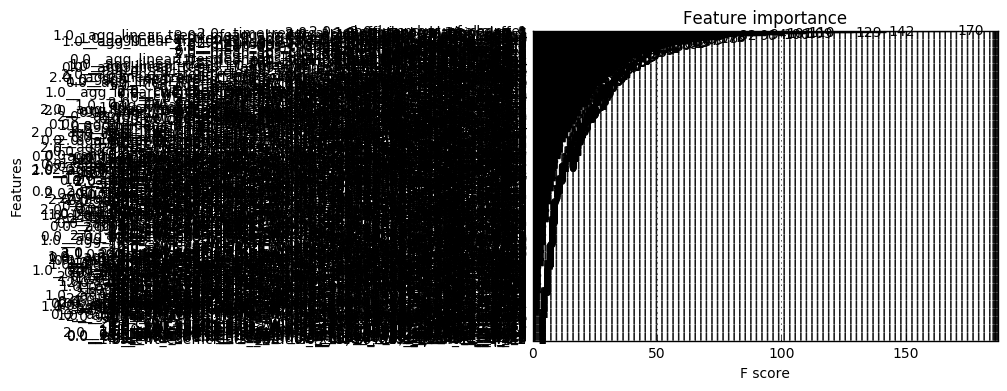

In [84]:
from xgboost import plot_importance,plot_tree,to_graphviz
from matplotlib import pyplot
plot_importance(cl)
pyplot.show()

- 画出排序后的XGBoost特征重要性数值

In [85]:
score = accuracy_score(y_test, cl.predict(X_test))
print(score)
from sklearn.feature_selection import SelectFromModel
thresholds = np.sort(cl.feature_importances_)
print(cl.feature_importances_.shape)

for thresh in thresholds:
    if thresh<0.01:
        continue
    # select features using threshold
    selection = SelectFromModel(cl, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    #predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

0.903846153846
(825,)
Thresh=0.010, n=8, Accuracy: 81.59%
Thresh=0.011, n=7, Accuracy: 81.32%
Thresh=0.011, n=6, Accuracy: 81.32%
Thresh=0.012, n=5, Accuracy: 79.95%
Thresh=0.012, n=4, Accuracy: 79.12%
Thresh=0.014, n=3, Accuracy: 76.37%
Thresh=0.016, n=2, Accuracy: 71.70%
Thresh=0.019, n=1, Accuracy: 31.32%


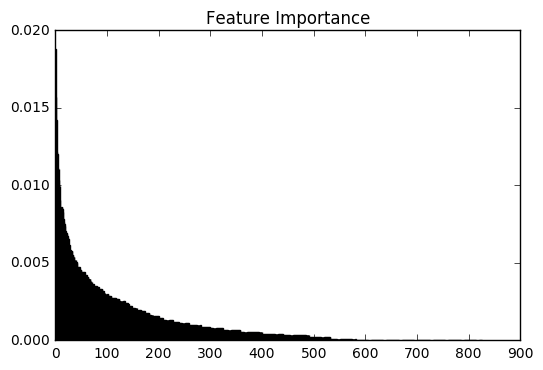

In [86]:
# plot
ind = np.argsort(-cl.feature_importances_)
plt.bar(range(len(cl.feature_importances_)), cl.feature_importances_[ind])
plt.title('Feature Importance')
plt.show()

- 混淆矩阵

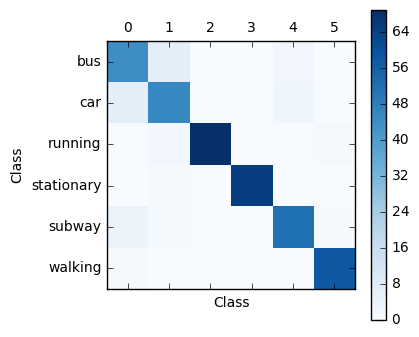

In [10]:
from sklearn.metrics import confusion_matrix

confusion = pd.DataFrame(confusion_matrix(y_test, cl.predict(X_test)))

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, range(0,6))
    plt.yticks(tick_marks, travel)
    #plt.tight_layout()
    plt.ylabel('Class')
    plt.xlabel('Class')

plot_confusion_matrix(confusion)

## 分层模型

In [11]:
def firstLevelY(kind, y):
    for i in xrange(0, kind.shape[0]):
        for j, n in enumerate(kind[i]):
            y[np.nonzero(y==n)] = i
    return y

kind = np.array([[0, 1, 4], [2, 3, 5]])
y_train_hier = copy.deepcopy(y_train.values)
y_train_hier = pd.Series(firstLevelY(kind, y_train_hier))
y_val_hier = copy.deepcopy(y_val.values)
y_val_hier = pd.Series(firstLevelY(kind, y_val_hier))
y_test_hier = copy.deepcopy(y_test.values)
y_test_hier = pd.Series(firstLevelY(kind, y_test_hier))

### 训练第一层模型

In [12]:
eval_set = [(X_val, y_val_hier)]
cl_1st = XGBClassifier(max_depth=6, n_estimators=200, objective='binary:logistic', reg_lambda=1)
cl_1st.fit(X_train, y_train_hier, eval_metric='error', eval_set=eval_set, early_stopping_rounds=30, verbose=False)
score = accuracy_score(y_test_hier, cl_1st.predict(X_test))
print(score)

0.980769230769


### 训练第二层模型

In [13]:
X_train_human = X_train.iloc[np.nonzero(y_train_hier.values)[0],:]
y_train_human = pd.Series(y_train.values[np.nonzero(y_train_hier.values)[0]])
X_val_human = X_val.iloc[np.nonzero(y_val_hier.values)[0],:]
y_val_human = pd.Series(y_val.values[np.nonzero(y_val_hier.values)[0]])
X_test_human = X_test.iloc[np.nonzero(y_test_hier.values)[0],:]
y_test_human = pd.Series(y_test.values[np.nonzero(y_test_hier.values)[0]])

X_train_motor = X_train.iloc[np.nonzero(y_train_hier.values==0)[0],:]
y_train_motor = pd.Series(y_train.values[np.nonzero(y_train_hier.values==0)[0]])
X_val_motor = X_val.iloc[np.nonzero(y_val_hier.values==0)[0],:]
y_val_motor = pd.Series(y_val.values[np.nonzero(y_val_hier.values==0)[0]])
X_test_motor = X_test.iloc[np.nonzero(y_test_hier.values==0)[0],:]
y_test_motor = pd.Series(y_test.values[np.nonzero(y_test_hier.values==0)[0]])

############### Human Model ################
eval_set = [(X_val_human, y_val_human)]
cl_human = XGBClassifier(max_depth=6, n_estimators=200, objective='multi:softmax', reg_lambda=1)
cl_human.fit(X_train_human, y_train_human, eval_metric='merror', eval_set=eval_set, early_stopping_rounds=30, verbose=False)
score = accuracy_score(y_test_human, cl_human.predict(X_test_human))
print(score)

############## Motor Model #################
eval_set = [(X_val_motor, y_val_motor)]
cl_motor = XGBClassifier(max_depth=5, n_estimators=200, objective='multi:softmax', reg_lambda=1)
cl_motor.fit(X_train_motor, y_train_motor, eval_metric='merror', eval_set=eval_set, early_stopping_rounds=30, verbose=False)
score = accuracy_score(y_test_motor, cl_motor.predict(X_test_motor))
print(score)

0.97461928934
0.832335329341


### Evaluation

In [14]:
y_pred_1st = cl_1st.predict(X_test)
correct = set(np.nonzero(y_pred_1st == y_test_hier.values)[0])
error_num = y_test.shape[0] - len(correct)
X_test_human = X_test.iloc[list(set(np.nonzero(y_test_hier.values)[0]) & correct), :]
y_test_human = y_test.iloc[list(set(np.nonzero(y_test_hier.values)[0]) & correct)]
X_test_motor = X_test.iloc[list(set(np.nonzero(y_test_hier.values==0)[0]) & correct), :]
y_test_motor = y_test.iloc[list(set(np.nonzero(y_test_hier.values==0)[0]) & correct)]

y_pred_human = cl_human.predict(X_test_human)
error_num += np.nonzero(y_pred_human != y_test_human.values)[0].size
y_pred_motor = cl_motor.predict(X_test_motor)
error_num += np.nonzero(y_pred_motor != y_test_motor.values)[0].size
print('Score = %f' % (1-float(error_num)/y_test.shape[0]))

Score = 0.898352


# 杂项

- 多次划分数据集并用XBGoost分类，以求出平均准确率及其方差

In [ ]:
#20Hz, 4s, no validation, 0.3 test data, 0.913, std = 0.012821
for i in xrange(3, 4):
    score = []
    for j in xrange(0, 100):
        #X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=.2)
        #X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=.125)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1*i)
        #eval_set = [(X_val, y_val)]
        cl = XGBClassifier(max_depth=5, n_estimators=300, objective='multi:softmax', reg_lambda=2)
        #cl.fit(X_train, y_train, eval_metric='mlogloss', eval_set=eval_set, early_stopping_rounds=20, verbose=False)
        cl.fit(X_train, y_train)
        score.append(accuracy_score(y_test, cl.predict(X_test)))
        print(score[-1])
    print('test size = %f, Mean accuracy is %f, std = %f' % (0.1*i, np.mean(score), np.std(score)))
    

0.913919413919
0.913919413919
0.906593406593
0.919413919414
0.901098901099
0.912087912088
0.906593406593
0.90293040293
0.919413919414
0.904761904762
0.895604395604
0.913919413919
0.92673992674
0.941391941392
0.917582417582
0.908424908425
0.912087912088
0.915750915751


- 多次划分数据集并用XBGoost分类，每次保存重要性排在前100的特征，最后取出现次数超过一半循环次数的特征，以便特征分析

In [ ]:
cand = 100
loop = 20
selected_ftr = np.array([])
mean = 0
for i in xrange(0, loop):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    X_train_fs, X_val, y_train_fs, y_val = train_test_split(X_train, y_train, test_size=.25)
    
    eval_set = [(X_val, y_val)]
    cl = XGBClassifier(max_depth=5, n_estimators=200, objective='multi:softmax', reg_lambda=2)
    cl.fit(X_train, y_train, eval_metric='mlogloss', eval_set=eval_set, early_stopping_rounds=20, verbose=False)
    score = accuracy_score(y_test, cl.predict(X_test))

    mean += score
    print('Loop %d, accuracy is %f' % (i, score))
    selected_ftr = np.append(selected_ftr, np.argsort(-cl.feature_importances_)[:cand])
print('Mean Accuracy is %f' % (mean/loop))

ftr = []
for key, value in dict(Counter(list(selected_ftr))).iteritems():
    if value >= loop*1/2:
        ftr.append(key)
ftr2 = X.columns.values[ftr]

- SFFS

In [ ]:
#20Hz, 4s, no validation, 0.3 test data, 0.913, std = 0.012821
from SFFS import SFFS

selected_ftr = []
for i in xrange(0, 20):
    X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=.125)
    eval_set = [(X_val, y_val)]
    SFFS_ftr = SFFS(X_train, y_train, X_val, y_val)
    
    for j, s in enumerate(SFFS_ftr):
        SFFS_ftr[j] = s[3:]
    
    selected_ftr.extend(SFFS_ftr)
    print('Loop = %d' % (i+1))

In [ ]:
SFFS_ftr = SFFS(X_train_fs, y_train_fs, X_val, y_val)